# Fraud Detection Data Analysis with PySpark

This code initializes a PySpark session and imports necessary libraries for data analysis, transformation, and visualization of fraud transaction data. Key components include:

- **SparkSession Setup**: Establishes a local Spark session with a specified app name and memory allocation.
- **PySpark Functions and Types**: Imports Spark SQL functions, custom UDFs, and data types to support data manipulation, cleaning, and type conversions.
- **Data Visualization Libraries**: Imports `matplotlib` for data plotting, allowing visual insights into transaction patterns.

This setup forms the foundation for processing and analyzing large datasets in a local Spark environment.


In [7]:
import kagglehub

path = kagglehub.dataset_download("jinquan/cc-sample-data")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\cy\.cache\kagglehub\datasets\jinquan\cc-sample-data\versions\1


In [8]:
from pyspark.sql import SparkSession, functions as F
from pyspark.sql.types import (
    StructType, StructField, StringType, DoubleType, IntegerType, 
    TimestampType, FloatType
)
from pyspark.sql.functions import (
    col, from_json, to_timestamp, sha2, split, expr, when, lit, udf, 
    length, from_unixtime, from_utc_timestamp, date_format, isnan, 
    regexp_replace, trim, count, size
)

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
import seaborn as sns
from datetime import datetime


spark = SparkSession.builder \
    .appName("Fraud Transaction Data Analysis") \
    .master("local[*]") \
    .config("spark.executor.memory", "4g") \
    .getOrCreate()




In [9]:
file_path = r"C:\Users\cy\.cache\kagglehub\datasets\jinquan\cc-sample-data\versions\1\cc_sample_transaction.json"

df = spark.read.json(file_path)

df.show(5)

+----------+------+-------------+-----------+----------------+--------+----------------+----------------------+------------------+-----------+-------------+--------------------+--------------------+---------------------+--------------------+
|Unnamed: 0|   amt|     category|     cc_bic|          cc_num|is_fraud|  merch_eff_time|merch_last_update_time|         merch_lat| merch_long|merch_zipcode|            merchant|     personal_detail|trans_date_trans_time|           trans_num|
+----------+------+-------------+-----------+----------------+--------+----------------+----------------------+------------------+-----------+-------------+--------------------+--------------------+---------------------+--------------------+
|         0|  4.97|     misc_net|CITIUS33CHI|2703186189652095|       0|1325376018798532|         1325376018666|         36.011293| -82.048315|        28705|fraud_Rippin, Kub...|{"person_name":"J...|  2019-01-01 00:00:18|0b242abb623afc578...|
|         1|107.23|  grocery_pos

In [10]:
df.printSchema()

root
 |-- Unnamed: 0: string (nullable = true)
 |-- amt: string (nullable = true)
 |-- category: string (nullable = true)
 |-- cc_bic: string (nullable = true)
 |-- cc_num: string (nullable = true)
 |-- is_fraud: string (nullable = true)
 |-- merch_eff_time: string (nullable = true)
 |-- merch_last_update_time: string (nullable = true)
 |-- merch_lat: string (nullable = true)
 |-- merch_long: string (nullable = true)
 |-- merch_zipcode: string (nullable = true)
 |-- merchant: string (nullable = true)
 |-- personal_detail: string (nullable = true)
 |-- trans_date_trans_time: string (nullable = true)
 |-- trans_num: string (nullable = true)



# Schema Definition and JSON Parsing for Transaction Data

This code defines schemas and extracts nested JSON data from a `personal_detail` field within a transaction dataset. Key steps include:

1. **Schema Creation**:
   - `address_schema`: Defines the structure for the address details (street, city, state, zip).
   - `personal_detail_schema`: Structures other personal attributes such as name, gender, coordinates, and job.

2. **JSON Parsing**:
   - Parses `personal_detail` into a structured format, enabling easy access to nested fields.
   - Extracts `address` details separately using the `address_schema`.

3. **Data Flattening**:
   - Selects and flattens relevant columns, creating `df_flat` for a streamlined dataset.
   - Drops nested JSON columns to maintain a clean and concise dataframe for further analysis.

This structure enables efficient querying and manipulation of complex nested JSON data within Spark.


In [11]:
# Define schema for the address field within personal_detail
address_schema = StructType([
    StructField("street", StringType(), True),
    StructField("city", StringType(), True),
    StructField("state", StringType(), True),
    StructField("zip", StringType(), True)
])

# Define schema for the personal_detail field
personal_detail_schema = StructType([
    StructField("person_name", StringType(), True),
    StructField("gender", StringType(), True),
    StructField("address", StringType(), True), 
    StructField("lat", StringType(), True),
    StructField("long", StringType(), True),
    StructField("city_pop", StringType(), True),
    StructField("job", StringType(), True),
    StructField("dob", StringType(), True)
])

# Parse the personal_detail JSON string
df = df.withColumn("personal_detail_struct", from_json(col("personal_detail"), personal_detail_schema))

# Parse the address JSON string within personal_detail
df = df.withColumn("address_struct", from_json(col("personal_detail_struct.address"), address_schema))


df_flat = df.select(
    col("Unnamed: 0").alias("id"),
    "trans_date_trans_time",
    "cc_num",
    "cc_bic",
    "merchant",
    "category",
    "amt",
    "trans_num",
    "merch_lat",
    "merch_long",
    "is_fraud",
    "merch_zipcode",
    "merch_eff_time",
    "merch_last_update_time",
    col("personal_detail_struct.person_name").alias("person_name"),
    col("personal_detail_struct.gender").alias("gender"),
    col("address_struct.street").alias("street"),
    col("address_struct.city").alias("city"),
    col("address_struct.state").alias("state"),
    col("address_struct.zip").alias("zip"),
    col("personal_detail_struct.lat").alias("lat"),
    col("personal_detail_struct.long").alias("long"),
    col("personal_detail_struct.city_pop").alias("city_pop"),
    col("personal_detail_struct.job").alias("job"),
    col("personal_detail_struct.dob").alias("dob")
)

# Drop the nested JSON columns
df_flat = df_flat.drop("personal_detail", "personal_detail_struct", "address_struct")


df_flat.show(truncate=False)


+---+---------------------+-------------------+-----------+----------------------------------------+-------------+------+--------------------------------+------------------+------------------+--------+-------------+----------------+----------------------+-------------------------+------+------------------------------+------------------------+-----+-----+-------+------------------+--------+---------------------------------------------+----------+
|id |trans_date_trans_time|cc_num             |cc_bic     |merchant                                |category     |amt   |trans_num                       |merch_lat         |merch_long        |is_fraud|merch_zipcode|merch_eff_time  |merch_last_update_time|person_name              |gender|street                        |city                    |state|zip  |lat    |long              |city_pop|job                                          |dob       |
+---+---------------------+-------------------+-----------+----------------------------------------+

# Data Type Conversion and Name Processing in Transaction Data

This code performs data cleaning and transformation on specific fields in the `df_flat` DataFrame:

1. **Data Type Conversion**:
   - Converts `amt` to `FloatType` for transaction amounts.
   - Converts `city_pop` to `IntegerType` for population figures.
   - Converts `trans_date_trans_time` to `TimestampType` for timestamp consistency.

2. **Name Cleaning and Splitting**:
   - Cleans the `person_name` field by removing non-alphabetic characters.
   - Splits the cleaned name into separate parts and extracts the first and last names, handling cases with single-part names.

3. **Column Cleanup**:
   - Drops the original `person_name`, `cleaned_name`, and `name_parts` columns, leaving only `first` and `last` for simplified name fields.

This ensures consistent data types for numerical fields and structures name data for further processing or analysis.


In [12]:
# Convert data types for specific fields
df_flat = df_flat.withColumn("amt", col("amt").cast(FloatType())) \
                 .withColumn("city_pop", col("city_pop").cast(IntegerType())) \
                 .withColumn("trans_date_trans_time", col("trans_date_trans_time").cast(TimestampType()))

# Clean the person_name column by replacing unwanted characters with spaces
df_flat = df_flat.withColumn("cleaned_name", regexp_replace(col("person_name"), r'[^a-zA-Z ]', ' '))

# Split the cleaned name by space
df_flat = df_flat.withColumn("name_parts", split(col("cleaned_name"), " "))

# Extract first and last names, handling cases where only one part is available
df_flat = df_flat.withColumn("first", trim(col("name_parts").getItem(0))) \
                 .withColumn("last", when(size(col("name_parts")) > 1, trim(col("name_parts").getItem(1))).otherwise(""))

# Drop old columns
df_flat = df_flat.drop("person_name", "cleaned_name", "name_parts")

df_flat.show(truncate=False)


+---+---------------------+-------------------+-----------+----------------------------------------+-------------+------+--------------------------------+------------------+------------------+--------+-------------+----------------+----------------------+------+------------------------------+------------------------+-----+-----+-------+------------------+--------+---------------------------------------------+----------+-----------+---------+
|id |trans_date_trans_time|cc_num             |cc_bic     |merchant                                |category     |amt   |trans_num                       |merch_lat         |merch_long        |is_fraud|merch_zipcode|merch_eff_time  |merch_last_update_time|gender|street                        |city                    |state|zip  |lat    |long              |city_pop|job                                          |dob       |first      |last     |
+---+---------------------+-------------------+-----------+----------------------------------------+--------

In [13]:

df_flat.select("last","trans_date_trans_time", "merch_eff_time", "merch_last_update_time").show(truncate=False)



+---------+---------------------+----------------+----------------------+
|last     |trans_date_trans_time|merch_eff_time  |merch_last_update_time|
+---------+---------------------+----------------+----------------------+
|Banks    |2019-01-01 00:00:18  |1325376018798532|1325376018666         |
|Gill     |2019-01-01 00:00:44  |1325376044867960|132537604479          |
|Sanchez  |2019-01-01 00:00:51  |1325376051506840|1325376051286         |
|White    |2019-01-01 00:01:16  |1325376076794698|1325376076365         |
|Garcia   |2019-01-01 00:03:06  |1325376186746376|132537618681          |
|Conner   |2019-01-01 00:04:08  |1325376248271406|1325376248483         |
|         |2019-01-01 00:04:42  |1325376282274130|1325376282247         |
|         |2019-01-01 00:05:08  |1325376308837349|1325376308152         |
|         |2019-01-01 00:05:18  |1325376318245892|1325376318278         |
|Aguilar  |2019-01-01 00:06:01  |1325376361965234|1325376361857         |
|Mendez   |2019-01-01 00:06:23  |13253

# Time Conversion and Validation in Transaction Data

This code refines time fields by converting, validating, and adjusting timestamps within the `df_flat` DataFrame:

1. **Microsecond to Second Conversion**:
   - Converts `merch_eff_time` from microseconds to seconds for compatibility in timestamp functions.

2. **Timestamp Length Validation**:
   - Computes the length of `merch_eff_time` and `merch_last_update_time` fields to ensure they meet expected digit lengths (16 and 13, respectively).

3. **Conditional Time Conversion**:
   - Converts `merch_eff_time` to a formatted timestamp if it has 16 digits, otherwise marks as "Invalid Timestamp."
   - Converts `merch_last_update_time` to a formatted timestamp if it has 13 digits, otherwise marks as "Invalid Timestamp."

4. **Timezone Adjustment**:
   - Converts `trans_date_trans_time` to Singapore Time (UTC+8) for regional consistency.

These transformations ensure accurate and validated time formats across different fields.


In [14]:
# Convert 'merch_eff_time' from microseconds to seconds
df_flat = df_flat.withColumn(
    "merch_eff_time_seconds", 
    (col("merch_eff_time") / 1e6).cast("double")
)

# Determine the length of each 'merch_eff_time' and 'merch_last_update_time' entry
df_flat = df_flat.withColumn(
    "merch_eff_time_length",
    length(col("merch_eff_time").cast("string"))
).withColumn(
    "merch_last_update_time_length",
    length(col("merch_last_update_time").cast("string"))
)

# Convert 'merch_eff_time' only if it has 16 digits; else, mark as invalid
df_flat = df_flat.withColumn(
    "merch_eff_time_converted",
    when(
        col("merch_eff_time_length") == 16,
        date_format(
            from_utc_timestamp(
                from_unixtime(col("merch_eff_time_seconds")),
                'Asia/Singapore'
            ),
            "yyyy-MM-dd HH:mm:ss.SSSSSS XXX"
        )
    ).otherwise(lit("Invalid Timestamp"))
)

# Convert 'merch_last_update_time' only if it has 13 digits; else, mark as invalid
df_flat = df_flat.withColumn(
    "merch_last_update_time_converted",
    when(
        col("merch_last_update_time_length") == 13,
        date_format(
            from_utc_timestamp(
                from_unixtime(col("merch_last_update_time") / 1e3),
                'Asia/Singapore'
            ),
            "yyyy-MM-dd HH:mm:ss.SSSSSS XXX"
        )
    ).otherwise(lit("Invalid Timestamp"))
)

# Convert 'trans_date_trans_time' to 'Asia/Singapore' timezone (UTC8)
df_flat = df_flat.withColumn(
    "trans_date_trans_time_converted",
    date_format(
        from_utc_timestamp(
            to_timestamp(col("trans_date_trans_time"), "yyyy-MM-dd HH:mm:ss"),
            'Asia/Singapore'
        ),
        "yyyy-MM-dd HH:mm:ss.SSSSSS XXX"
    )
)






In [15]:
#  Drop columns 
df_flat = df_flat.drop("merch_eff_time_seconds","merch_eff_time_length","merch_last_update_time_length","merch_eff_time","merch_last_update_time","trans_date_trans_time")


df_flat.show(truncate=False)


+---+-------------------+-----------+----------------------------------------+-------------+------+--------------------------------+------------------+------------------+--------+-------------+------+------------------------------+------------------------+-----+-----+-------+------------------+--------+---------------------------------------------+----------+-----------+---------+---------------------------------+---------------------------------+---------------------------------+
|id |cc_num             |cc_bic     |merchant                                |category     |amt   |trans_num                       |merch_lat         |merch_long        |is_fraud|merch_zipcode|gender|street                        |city                    |state|zip  |lat    |long              |city_pop|job                                          |dob       |first      |last     |merch_eff_time_converted         |merch_last_update_time_converted |trans_date_trans_time_converted  |
+---+-------------------+---

In [16]:
spark.conf.get("spark.sql.session.timeZone")


'Asia/Singapore'

In [17]:
df_flat.select("last","trans_date_trans_time_converted", "merch_eff_time_converted", "merch_last_update_time_converted").show(truncate=False)

+---------+---------------------------------+---------------------------------+---------------------------------+
|last     |trans_date_trans_time_converted  |merch_eff_time_converted         |merch_last_update_time_converted |
+---------+---------------------------------+---------------------------------+---------------------------------+
|Banks    |2019-01-01 08:00:18.000000 +08:00|2012-01-01 16:00:18.000000 +08:00|2012-01-01 16:00:18.000000 +08:00|
|Gill     |2019-01-01 08:00:44.000000 +08:00|2012-01-01 16:00:44.000000 +08:00|Invalid Timestamp                |
|Sanchez  |2019-01-01 08:00:51.000000 +08:00|2012-01-01 16:00:51.000000 +08:00|2012-01-01 16:00:51.000000 +08:00|
|White    |2019-01-01 08:01:16.000000 +08:00|2012-01-01 16:01:16.000000 +08:00|2012-01-01 16:01:16.000000 +08:00|
|Garcia   |2019-01-01 08:03:06.000000 +08:00|2012-01-01 16:03:06.000000 +08:00|Invalid Timestamp                |
|Conner   |2019-01-01 08:04:08.000000 +08:00|2012-01-01 16:04:08.000000 +08:00|2012-01-0

In [18]:
df_flat.filter(col("merch_eff_time_converted") == "Invalid Timestamp").count()

129251

In [19]:
df_flat.filter(col("merch_last_update_time_converted") == "Invalid Timestamp").count()

129462

# Data Quality Checks for Transaction Dataset

This code performs a series of data quality checks on essential columns in `df_flat` to ensure completeness, uniqueness, and validity:

1. **Missing Value Check**:
   - Checks for missing values in critical columns (`cc_num`, `trans_date_trans_time`, `amt`, and `trans_num`).
   
2. **Uniqueness Check**:
   - Validates the uniqueness of `trans_num` by identifying any duplicate transaction numbers.

3. **Negative Amount Check**:
   - Counts any records where `amt` (transaction amount) is negative, as these may indicate errors.

4. **Date Range Validation**:
   - Ensures `trans_date_trans_time` falls within the expected date range (2000 to 2030).
   
5. **Invalid Timestamp Checks**:
   - Identifies invalid timestamps in `merch_last_update_time_converted` and `merch_eff_time_converted` columns, marking entries that don’t meet digit length criteria.

6. **Summary of Data Quality Results**:
   - Outputs a concise summary of missing values, duplicate transactions, negative amounts, and invalid timestamps.

These checks enhance the data's reliability, ensuring that only valid, complete, and unique records are used in further analysis.


In [20]:
essential_columns = ["cc_num", "trans_date_trans_time", "amt", "trans_num"]

for column in essential_columns:
    missing_count = df_flat.filter(col(column).isNull()).count()


# Uniqueness Check for `trans_num`

duplicate_trans_num = df_flat.groupBy("trans_num").count().filter(col("count") > 1)
duplicate_trans_num_count = duplicate_trans_num.count()

if duplicate_trans_num_count > 0:
    duplicate_trans_num.show(truncate=False)



# Check for Negative Amounts
invalid_amounts = df_flat.filter(col("amt") < 0).count()

# Define expected date ranges
min_date = datetime(2000, 1, 1)
max_date = datetime(2030, 1, 1)

# Check for Invalid `trans_date_trans_time`
invalid_trans_date = df_flat.filter(
    to_timestamp(col("trans_date_trans_time"), "yyyy-MM-dd HH:mm:ss").isNull() |
    ~to_timestamp(col("trans_date_trans_time"), "yyyy-MM-dd HH:mm:ss").between(lit(min_date), lit(max_date))
).count()
if invalid_trans_date > 0:
    df_flat.filter(
        to_timestamp(col("trans_date_trans_time"), "yyyy-MM-dd HH:mm:ss").isNull() |
        ~to_timestamp(col("trans_date_trans_time"), "yyyy-MM-dd HH:mm:ss").between(lit(min_date), lit(max_date))
    ).select("trans_date_trans_time").show(truncate=False)

# Check for Invalid `merch_last_update_time`
invalid_merch_last_update_time = df_flat.filter(
    (col("merch_last_update_time_converted") == "Invalid Timestamp")
).count()
if invalid_merch_last_update_time > 0:
    df_flat.filter(col("merch_last_update_time_converted") == "Invalid Timestamp") \
           .select("merch_last_update_time_converted")

# Check for Invalid `merch_eff_time`
invalid_merch_eff_time = df_flat.filter(
    (col("merch_eff_time_converted") == "Invalid Timestamp")
).count()
if invalid_merch_eff_time > 0:
    df_flat.filter(col("merch_eff_time_converted") == "Invalid Timestamp") \
           .select("merch_eff_time_converted")

# Summary of Data Quality Checks
print("\n=== Data Quality Summary ===")
print("1. Missing Values:")
for column in essential_columns:
    missing_count = df_flat.filter(col(column).isNull()).count()
    print(f"   - {column}: {missing_count} missing")

print(f"Duplicate Transactions: {duplicate_trans_num_count} found")
print(f"Negative Transaction Amounts: {invalid_amounts} found")
print("Invalid Timestamps:")
print(f"   - trans_date_trans_time: {invalid_trans_date} invalid")
print(f"   - merch_last_update_time: {invalid_merch_last_update_time} invalid")
print(f"   - merch_eff_time: {invalid_merch_eff_time} invalid")



=== Data Quality Summary ===
1. Missing Values:
   - cc_num: 0 missing
   - trans_date_trans_time: 0 missing
   - amt: 0 missing
   - trans_num: 0 missing
Duplicate Transactions: 0 found
Negative Transaction Amounts: 0 found
Invalid Timestamps:
   - trans_date_trans_time: 0 invalid
   - merch_last_update_time: 129462 invalid
   - merch_eff_time: 129251 invalid


# Data Cleaning, PII Protection, and Masking in Transaction Data

This code refines the transaction dataset by filtering invalid timestamps and applying data protection measures for Personally Identifiable Information (PII):

1. **Invalid Timestamp Removal**:
   - Filters out rows where `merch_eff_time_converted` or `merch_last_update_time_converted` is labeled "Invalid Timestamp."

2. **PII Encryption and Masking**:
   - Encrypts sensitive data such as `cc_num`, `cc_bic`, and `street` using SHA-256.
   - Applies masking techniques to names (`first` and `last` masked to initials) and postal code (`zip` masked to the first three digits).
   - Generalizes geographic coordinates (`lat` and `long`) by rounding to the first decimal.
   - Extracts only the birth year from `dob`.

3. **Dropping Original PII Columns**:
   - Removes unprotected PII columns, retaining only the encrypted, masked, or generalized versions.

These steps ensure compliance with data protection requirements while retaining essential data insights.


In [21]:
# Remove rows where `merch_eff_time_converted` or `merch_last_update_time_converted` =="Invalid Timestamp"
df_cleaned = df_flat.filter(
    (col("merch_eff_time_converted") != "Invalid Timestamp") &
    (col("merch_last_update_time_converted") != "Invalid Timestamp")
)

# Apply encryption and masking for PII
df_protected = df_cleaned \
    .withColumn("cc_num_encrypted", sha2(col("cc_num"), 256)) \
    .withColumn("cc_bic_encrypted", sha2(col("cc_bic"), 256)) \
    .withColumn("first_masked", expr("substring(first, 1, 1)")) \
    .withColumn("last_masked", expr("substring(last, 1, 1)")) \
    .withColumn("dob_year", expr("year(dob)")) \
    .withColumn("street_encrypted", sha2(col("street"), 256)) \
    .withColumn("city_hashed", sha2(col("city"), 256)) \
    .withColumn("state_hashed", sha2(col("state"), 256)) \
    .withColumn("zip_masked", expr("substring(zip, 1, 3)")) \
    .withColumn("lat_generalized", expr("round(lat, 1)")) \
    .withColumn("long_generalized", expr("round(long, 1)"))

# Drop the original PII columns
df_protected = df_protected.drop("cc_num", "cc_bic", "first", "last", "dob", "street", "city", "state", "zip", "lat", "long")


df_protected.show(truncate=False)


+---+----------------------------------------+-------------+------+--------------------------------+------------------+------------------+--------+-------------+------+--------+---------------------------+---------------------------------+---------------------------------+---------------------------------+----------------------------------------------------------------+----------------------------------------------------------------+------------+-----------+--------+----------------------------------------------------------------+----------------------------------------------------------------+----------------------------------------------------------------+----------+---------------+----------------+
|id |merchant                                |category     |amt   |trans_num                       |merch_lat         |merch_long        |is_fraud|merch_zipcode|gender|city_pop|job                        |merch_eff_time_converted         |merch_last_update_time_converted |trans_date_trans

# Comprehensive Transaction and Fraud Analysis

This code performs data analysis on the transaction dataset, producing visualizations that explore fraud rates, trends, and patterns:

1. **Data Type Adjustment**:
   - Ensures `is_fraud` is an integer, `amt` is a float, and `trans_date_trans_time_converted` is a timestamp.

2. **Analysis Metrics**:
   - **Fraud Rate by Category**: Calculates the average fraud rate for each category.
   - **Fraud Amount Distribution**: Separates fraud and non-fraud transactions, displaying proportions.
   - **Fraud Trend Over Years**: Shows the yearly trend in fraud transactions.
   - **Fraud by Time of Day**: Displays fraud frequency by hour.
   - **Average Spend by Category**: Computes average transaction amounts per category.
   - **Fraud Trend Over Months**: Analyzes monthly fraud transaction counts.
   - **Top Merchants and Cities for Fraud**: Identifies the top 10 merchants and cities with the highest fraud counts.

3. **Visualizations**:
   - Eight subplots present fraud rate by category, fraud amount distribution, yearly fraud trends, hourly fraud distribution, average category spending, monthly fraud trends, top fraud-prone merchants, and cities.

These insights provide a comprehensive view of fraud distribution, enabling targeted fraud prevention strategies.


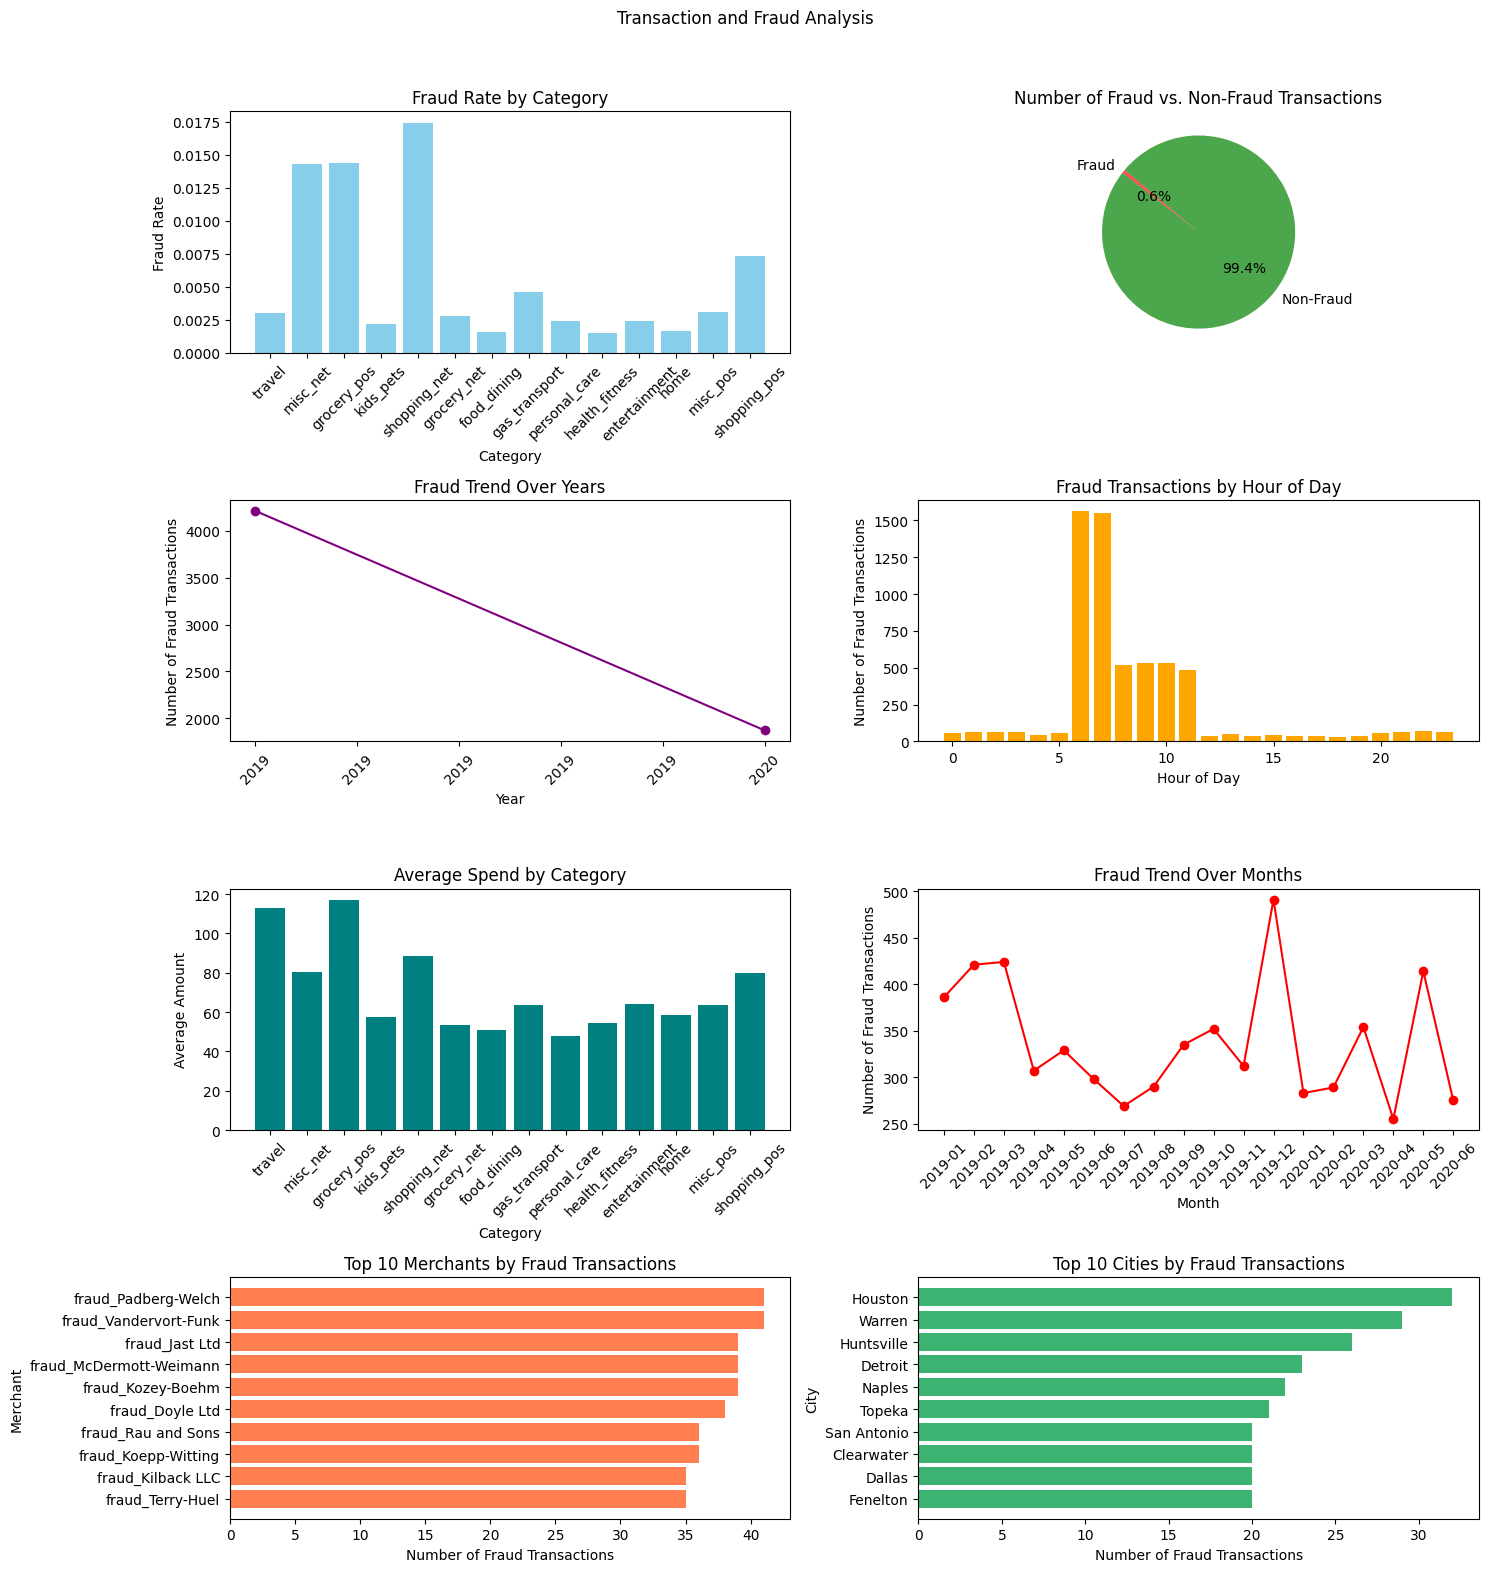

In [22]:
# Adjust data types
df_cleaned = df_cleaned.withColumn('is_fraud', F.col('is_fraud').cast('integer'))
df_cleaned = df_cleaned.withColumn('amt', F.col('amt').cast('float'))
df_cleaned = df_cleaned.withColumn('trans_date_trans_time_converted', F.to_timestamp('trans_date_trans_time_converted'))

# 1. Fraud Rate by Category
fraud_rate_by_category = df_cleaned.groupBy('category').agg(F.mean('is_fraud').alias('fraud_rate')).toPandas()

# 2. Fraud Amount Distribution (separating fraud and non-fraud)
fraud_amt = df_cleaned.filter(F.col('is_fraud') == 1).select('amt').sample(False, 0.1).toPandas()['amt']
non_fraud_amt = df_cleaned.filter(F.col('is_fraud') == 0).select('amt').sample(False, 0.1).toPandas()['amt']


# 3. Fraud Trend Over Years (Ensuring Year is in Integer Format)
fraud_trend_by_year = df_cleaned.filter(F.col('is_fraud') == 1) \
                                .groupBy(F.year('trans_date_trans_time_converted').alias('transaction_year')) \
                                .count().orderBy('transaction_year').toPandas()

# Convert the year to integer
fraud_trend_by_year['transaction_year'] = fraud_trend_by_year['transaction_year'].astype(int)


# Fraud by Time of Day
fraud_by_hour = df_cleaned.withColumn('transaction_hour', F.hour('trans_date_trans_time_converted')) \
                          .filter(F.col('is_fraud') == 1) \
                          .groupBy('transaction_hour').count().toPandas()

# Average Spend by Category
average_spend_by_category = df_cleaned.groupBy('category').agg(F.mean('amt').alias('average_spend')).toPandas()

# Fraud Trend Over Months
fraud_trend_by_month = df_cleaned.filter(F.col('is_fraud') == 1) \
                                 .groupBy(F.date_format('trans_date_trans_time_converted', 'yyyy-MM').alias('transaction_month')) \
                                 .count().orderBy('transaction_month').toPandas()

# Number of Fraud Transactions by Merchant (Top 10)
fraud_by_merchant = df_cleaned.filter(F.col('is_fraud') == 1) \
                              .groupBy('merchant').count() \
                              .orderBy(F.desc('count')).limit(10).toPandas()

# Number of Fraud Transactions by City (Top 10)
fraud_by_city = df_cleaned.filter(F.col('is_fraud') == 1) \
                          .groupBy('city').count() \
                          .orderBy(F.desc('count')).limit(10).toPandas()

# Plotting each analysis
fig, axs = plt.subplots(4, 2, figsize=(15, 16))
fig.suptitle('Transaction and Fraud Analysis')

# Plot 1: Fraud Rate by Category
axs[0, 0].bar(fraud_rate_by_category['category'], fraud_rate_by_category['fraud_rate'], color='skyblue')
axs[0, 0].set_title('Fraud Rate by Category')
axs[0, 0].set_xlabel('Category')
axs[0, 0].set_ylabel('Fraud Rate')
axs[0, 0].tick_params(axis='x', rotation=45)

# Plot 2: Fraud Amount Distribution
# Count fraud and non-fraud transactions
fraud_count = df_cleaned.filter(F.col('is_fraud') == 1).count()
non_fraud_count = df_cleaned.filter(F.col('is_fraud') == 0).count()

# Plot 2: Number of Fraud vs. Non-Fraud (Pie Chart)
axs[0, 1].pie([fraud_count, non_fraud_count], labels=['Fraud', 'Non-Fraud'], colors=['red', 'green'], autopct='%1.1f%%', startangle=140, wedgeprops={'alpha':0.7})
axs[0, 1].set_title('Number of Fraud vs. Non-Fraud Transactions')

# Plot 3: Fraud Trend Over Years
axs[1, 0].plot(fraud_trend_by_year['transaction_year'], fraud_trend_by_year['count'], marker='o', color='purple')
axs[1, 0].set_title('Fraud Trend Over Years')
axs[1, 0].set_xlabel('Year')
axs[1, 0].set_ylabel('Number of Fraud Transactions')

# Explicitly set x-axis tick formatter to display years as integers
axs[1, 0].xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: int(x)))
axs[1, 0].tick_params(axis='x', rotation=45)

# Plot 4: Fraud by Time of Day
axs[1, 1].bar(fraud_by_hour['transaction_hour'], fraud_by_hour['count'], color='orange')
axs[1, 1].set_title('Fraud Transactions by Hour of Day')
axs[1, 1].set_xlabel('Hour of Day')
axs[1, 1].set_ylabel('Number of Fraud Transactions')

# Plot 5: Average Spend by Category
axs[2, 0].bar(average_spend_by_category['category'], average_spend_by_category['average_spend'], color='teal')
axs[2, 0].set_title('Average Spend by Category')
axs[2, 0].set_xlabel('Category')
axs[2, 0].set_ylabel('Average Amount')
axs[2, 0].tick_params(axis='x', rotation=45)

# Plot 6: Fraud Trend Over Months
axs[2, 1].plot(fraud_trend_by_month['transaction_month'], fraud_trend_by_month['count'], marker='o', color='red')
axs[2, 1].set_title('Fraud Trend Over Months')
axs[2, 1].set_xlabel('Month')
axs[2, 1].set_ylabel('Number of Fraud Transactions')
axs[2, 1].tick_params(axis='x', rotation=45)

# Plot 7: Number of Fraud Transactions by Merchant (Top 10)
axs[3, 0].barh(fraud_by_merchant['merchant'], fraud_by_merchant['count'], color='coral')
axs[3, 0].set_title('Top 10 Merchants by Fraud Transactions')
axs[3, 0].set_xlabel('Number of Fraud Transactions')
axs[3, 0].set_ylabel('Merchant')
axs[3, 0].invert_yaxis()

# Plot 8: Number of Fraud Transactions by City (Top 10)
axs[3, 1].barh(fraud_by_city['city'], fraud_by_city['count'], color='mediumseagreen')
axs[3, 1].set_title('Top 10 Cities by Fraud Transactions')
axs[3, 1].set_xlabel('Number of Fraud Transactions')
axs[3, 1].set_ylabel('City')
axs[3, 1].invert_yaxis()  # Invert to have the highest fraud city on top



plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [23]:
print(fraud_trend_by_month)


   transaction_month  count
0            2019-01    386
1            2019-02    421
2            2019-03    424
3            2019-04    307
4            2019-05    329
5            2019-06    298
6            2019-07    269
7            2019-08    290
8            2019-09    335
9            2019-10    352
10           2019-11    312
11           2019-12    491
12           2020-01    283
13           2020-02    289
14           2020-03    354
15           2020-04    255
16           2020-05    414
17           2020-06    275


In [24]:
df_cleaned.printSchema()


root
 |-- id: string (nullable = true)
 |-- cc_num: string (nullable = true)
 |-- cc_bic: string (nullable = true)
 |-- merchant: string (nullable = true)
 |-- category: string (nullable = true)
 |-- amt: float (nullable = true)
 |-- trans_num: string (nullable = true)
 |-- merch_lat: string (nullable = true)
 |-- merch_long: string (nullable = true)
 |-- is_fraud: integer (nullable = true)
 |-- merch_zipcode: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- street: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- zip: string (nullable = true)
 |-- lat: string (nullable = true)
 |-- long: string (nullable = true)
 |-- city_pop: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- dob: string (nullable = true)
 |-- first: string (nullable = true)
 |-- last: string (nullable = true)
 |-- merch_eff_time_converted: string (nullable = true)
 |-- merch_last_update_time_converted: string (nullable = true)
 |